# FUSOR Demonstrative Analysis
This notebook contains a demonstrative analysis of the FUSOR package, showing how fusion events detected from patient samples at Nationwide Children's Hospital's Institute for Genomic Medicine (IGM) can be matched to the CIViC and Molecular Oncology Almanac (MOA) databases.

The cells below are run to set environment variables and load in FUSOR.

In [1]:
from os import environ
import logging
from pathlib import Path
from tqdm import tqdm

# These are the configurations for the UTA and SeqRepo databases. These should
# be adjusted by the user based on the locations where these databases exist.
environ["UTA_DB_URL"] = "postgresql://anonymous@localhost:5432/uta/uta_20241220"
environ["SEQREPO_ROOT_DIR"] = "/usr/local/share/seqrepo/2024-12-20"

logging.getLogger("cool_seq_tool").setLevel(logging.ERROR)

In [2]:
from fusor.fusor import FUSOR

fusor = FUSOR()

***Using Gene Database Endpoint: http://localhost:8000***


## Prepare and Load `CategoricalFusion` Data

### CIViC

The cell below loads from the saved CIViC cache (from 9/22/25) and creates a list of `CategoricalFusion` objects. We are filtering for `accepted` and `submitted` variants from CIViC.

In [3]:
from fusor.harvester import CIVICHarvester

harvester = CIVICHarvester(fusor=fusor, local_cache_path="data/caches/civic_cache_20250922.pkl", include_status=["accepted", "submitted"])
civic_fusions = await harvester.load_records()

ERROR:fusor.harvester:Cannot translate fusion: FGFR3(entrez:2261)::v due to the following reason: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
Traceback (most recent call last):
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/harvester.py", line 412, in load_records
    cat_fusion = await self.translator.translate(civic=fusion)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/translator.py", line 984, in translate
    raise ValueError(msg)
ValueError: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
ERROR:fusor.harvester:Cannot translate fusion: TCF3(entrez:6929)::PBX1(entrez:5087) due to the following reason: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
Traceback (most recent call last):
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/harvester.py", line 412, in load_records
    cat_fusion

### MOA

The cell below loads from the saved MOA cache (9/4/25) and creates a list of `CategoricalFusion` objects.

In [4]:
from fusor.harvester import MOAHarvester

harvester = MOAHarvester(fusor=fusor, cache_dir=Path("data/caches"), use_local=True)
moa_fusions = harvester.load_records()

## Translate `AssayedFusion` objects from EnFusion files

The cell below can be run to generate a list of translated `AssayedFusion` objects from a subset of EnFusion output from 18 samples patients at IGM. This cell takes around 6 minutes to run. The fusion events were detected at a sequencing depth of 200 million reads, and were returned if they were detected by three or more of the following fusion callers: FusionMap, FusionCatcher, JAFFA, STAR-Fusion, CICERO, Arriba.

In [5]:
from fusor.harvester import EnFusionHarvester
from cool_seq_tool.schemas import Assembly

harvester = EnFusionHarvester(fusor=fusor, assembly=Assembly.GRCH38)
assayed_fusions_enfusion = []
patient_ids = []
files = [patient_file.name for patient_file in Path("data/fusion-test-data").iterdir() if patient_file.is_file()]

for file in tqdm(files):
    fusions = await harvester.load_records(fusion_path=Path(f"data/fusion-test-data/{file}"))
    for fusion in fusions:
        patient_ids.append(file)
    assayed_fusions_enfusion.extend(fusions)

100%|██████████| 18/18 [06:07<00:00, 20.44s/it]


## 1. Use `FusionMatcher` to match patient fusions against CIViC and MOA

The cell below can be run to use the `FusionMatcher` module to match the translated EnFusion output, containting patient fusion data, against CIViC and MOA. Matches are prioritized and returned according to predefined [match criteria](https://github.com/cancervariants/fusor/wiki/Fusion-Match-Classes).

In [6]:
from fusor.fusion_matching import FusionMatcher

fm = FusionMatcher(assayed_fusions=assayed_fusions_enfusion,
                   comparator_fusions=civic_fusions + moa_fusions)

matches = await fm.match_fusion()

### Create Patient Variant Dictionary
The cell below can be run to create a dictionary containing the returned matching `CategoricalFusion` objects for each patient sample.

In [7]:
from collections import defaultdict

matches_ids = []
for match, id in zip(matches, patient_ids):
    if match:
        matches_ids.append((match, id))

patient_match_dict = defaultdict(list)

for tup in matches_ids:
    obj, pid = tup
    patient_match_dict[pid].append(tup[0])
patient_match_dict = dict(patient_match_dict)

## 2. Fusion Match Characterization
The cells below analyze the results of the matching analysis, describing the types of `CategoricalFusions` matches that are returned given an `AssayedFusion` query and the types of evidence that are associated with those matches.

The helper functions below are used throughout this section:

In [8]:
from fusor.models import CategoricalFusion
from fusor.fusion_matching import MatchType
from collections import Counter

def count_match_types(matches: list[tuple[CategoricalFusion, MatchType]]) -> dict:
    """Count the number of match types across a list of matching output
    
    :param matches: A list of tuples containing CategoricalFusion and MatchType 
        objects
    :return: A dictionarydescribing the number of fusions that belong in each 
        shared fusion match category"""
    element_counts = [match[1].priority // 10 for match in matches]
    element_counts = Counter(element_counts)
    map = {1: "exact", 2:"shared_genes_exact_one_partner", 3:"shared_genes", 
           4:"exact_one_partner", 5:"shared_gene_one_partner"}
    return {map[key]: value for key, value in element_counts.items()}

In [9]:
def count_match_types_patient(match_info: list[list[tuple[CategoricalFusion, MatchType]]]) -> dict[str, int]:
    """Count the number of match types that occur across a patient sample
    
    :param match_info: A list of list of tuples containing the match information
        for a patient sample
    :return: A dictionary describing match information at the patient level
    """
    categories = [
        "exact",
        "shared_genes_exact_one_partner",
        "shared_genes",
        "exact_one_partner",
        "shared_gene_one_partner",
    ]
    total_counts = Counter({cat: 0 for cat in categories})
    
    for match in match_info:
        match_dat = count_match_types(match)
        total_counts.update({k: match_dat.get(k, 0) for k in categories})
    
    return dict(total_counts)

### Get highest returned priority match type across patients
The cell below reports the highest priority type that is returned for the matching `CategoricalFusions` for each patient sample.

In [10]:
highest_priority = []
for patient in patient_match_dict:
    priority = count_match_types_patient(patient_match_dict[patient])
    for key in priority:
        if priority[key] > 0:
            highest_priority.append(key)
            break
highest_priority

['shared_genes',
 'exact',
 'shared_genes',
 'shared_genes_exact_one_partner',
 'exact',
 'shared_genes_exact_one_partner',
 'exact',
 'exact',
 'exact',
 'shared_genes',
 'exact',
 'shared_genes',
 'exact_one_partner',
 'shared_genes_exact_one_partner',
 'shared_genes',
 'shared_genes_exact_one_partner',
 'exact']

Run the cells below to visualize the highest fusion priority type that is returned for each patient sample.

In [11]:
import pandas as pd

columns = ["priority_type", "count"]
highest_priority_df = pd.DataFrame(columns=columns)
highest_priority_df["priority_type"] = ["exact", "shared_genes_exact_one_partner",
                                        "shared_genes",  "exact_one_partner",]
highest_priority_df["count"] = [7, 4, 5, 1]

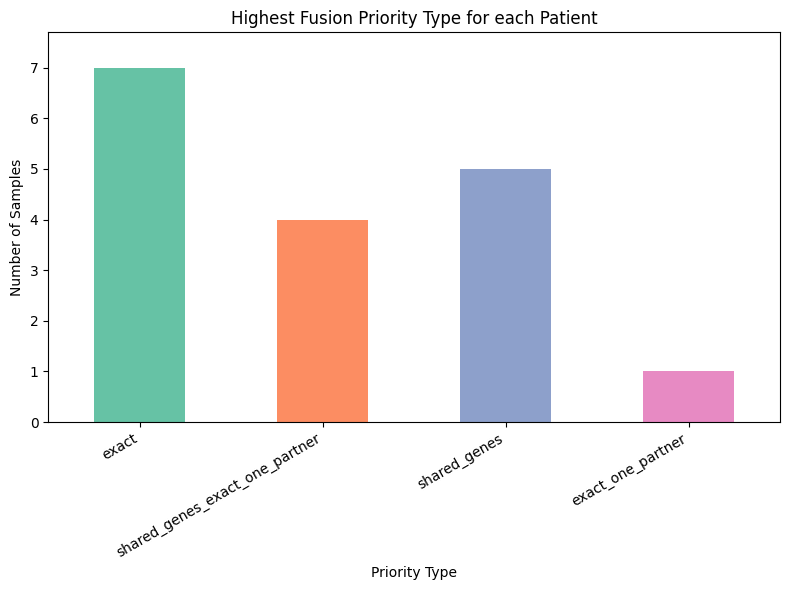

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

bar_colors = sns.color_palette("Set2")

ax = highest_priority_df.plot.bar(x="priority_type", y="count",
                                  title="Highest Fusion Priority Type for each Patient",
                                  figsize=(8, 6), color=bar_colors, legend=False)
plt.xlabel("Priority Type")
plt.ylabel("Number of Samples")
plt.xticks(rotation=30, ha="right")
plt.margins(x=0.05, y=0.1)
plt.tight_layout()  
plt.show()

### Compute Match Type Summary Statistics
Run the cell below to compute summary statistics describing the types of matches that were returned.

In [13]:
print(f"The number of translated fusion across the 18 examined patient files is: {len(assayed_fusions_enfusion)}")
print(f"The number of patient assayed fusions that had at least one match against CIViC and MOA is: {len([match for match in matches if match])}")

# Compute the number of match types across the different patient samples
priority_counts = [count_match_types_patient(patient_match_dict[patient]) for patient in patient_match_dict]
combined_counts = dict(sum((Counter(d) for d in priority_counts), Counter()))
categories = [
    "exact",
    "shared_genes_exact_one_partner",
    "shared_genes",
    "exact_one_partner",
    "shared_gene_one_partner",
]
combined_counts = {cat: combined_counts[cat] for cat in categories}
f"The breakdown of returned match types across the testing set is: {combined_counts}"

The number of translated fusion across the 18 examined patient files is: 2388
The number of patient assayed fusions that had at least one match against CIViC and MOA is: 207


"The breakdown of returned match types across the testing set is: {'exact': 21, 'shared_genes_exact_one_partner': 12, 'shared_genes': 91, 'exact_one_partner': 70, 'shared_gene_one_partner': 815}"

## 3. Clinical Evidence Comparison
